In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

%tensorflow_version 2.x
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

AUTOTUNE = tf.data.experimental.AUTOTUNE
print("AUTOTUNE: ", AUTOTUNE)

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

TensorFlow 2.x selected.
Num GPUs Available:  1
Found GPU at: /device:GPU:0
AUTOTUNE:  -1


In [4]:
import pathlib
project_dir = "/content/drive/My Drive/master_uppsala/p3_computer-assisted_image_analysis_2_project/"
oral_cancer_dataset_dir = project_dir + "OralCancer_DataSet3/"
train_dir = pathlib.Path(oral_cancer_dataset_dir + "train/")

CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')])
print(CLASS_NAMES)
total_train = 73303  # len(list(train_dir.glob('*/*/*.jpg')))  # 73303
total_test = 55514  # len(list(test_dir.glob('*/*/*.jpg')))  # 55514

BATCH_SIZE = 128
epochs = 30
IMG_HEIGHT = 80
IMG_WIDTH = 80

# from IPython.display import display
# image_example_dir = str(list(train_dir.glob('Cancer/000/*.jpg'))[0])
# display(Image.open(image_example_dir))

['Cancer' 'Healthy']


# **Load data by `tf.data`**

In [0]:
train_record_file = oral_cancer_dataset_dir + 'train_images.tfrecords'
test_record_file = oral_cancer_dataset_dir + 'test_images.tfrecords'

train_image_dataset = tf.data.TFRecordDataset(train_record_file)
test_image_dataset = tf.data.TFRecordDataset(test_record_file)
# Create a dictionary describing the features.
image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

train_ds = train_image_dataset.map(_parse_image_function)
test_ds = test_image_dataset.map(_parse_image_function)

# for a in test_ds.take(1):
#   raw_image = a['image_raw'].numpy()
#   label = a['label'].numpy()
#   print(label)
#   display.display(display.Image(raw_image))

In [0]:
def decode_img_label(x):
  def _decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # convert the compressed string to a 3D uint8 tensor
    return tf.image.convert_image_dtype(img, tf.float32)  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  
  img = _decode_img(x['image_raw'])
  label = (CLASS_NAMES == CLASS_NAMES[0]).astype(int) == x['label']
  return img, label

train_labeled_ds = train_ds.map(decode_img_label, num_parallel_calls=AUTOTUNE)
test_labeled_ds = test_ds.map(decode_img_label, num_parallel_calls=AUTOTUNE)

# for b in test_labeled_ds.take(1):
#   print(b[0].numpy())
#   print(b[1].numpy())

In [0]:
train_labeled_ds = train_labeled_ds.cache()
test_labeled_ds = test_labeled_ds.cache()

def augment(ds):
  lr_flip_ds = ds.map(lambda x,y: (tf.image.flip_left_right(x),y), num_parallel_calls=AUTOTUNE)
  ud_flip_ds = ds.map(lambda x,y: (tf.image.flip_up_down(x),y), num_parallel_calls=AUTOTUNE)
  rot90_ds = ds.map(lambda x,y: (tf.image.rot90(x),y), num_parallel_calls=AUTOTUNE)
  rot180_ds = ds.map(lambda x,y: (tf.image.rot90(x, k=2),y), num_parallel_calls=AUTOTUNE)
  rot270_ds = ds.map(lambda x,y: (tf.image.rot90(x, k=3),y), num_parallel_calls=AUTOTUNE)
  lr_flip_rot90_ds = lr_flip_ds.map(lambda x,y: (tf.image.rot90(x),y), num_parallel_calls=AUTOTUNE)
  lr_flip_rot270_ds = lr_flip_ds.map(lambda x,y: (tf.image.rot90(x, k=3),y), num_parallel_calls=AUTOTUNE)
  return ds.concatenate(lr_flip_ds).concatenate(ud_flip_ds).concatenate(rot90_ds).concatenate(rot180_ds).concatenate(rot270_ds).concatenate(lr_flip_rot90_ds).concatenate(lr_flip_rot270_ds)

train_augmented_ds = augment(train_labeled_ds)
test_augmented_ds = augment(test_labeled_ds)

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.repeat()  # Repeat forever
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)  # `prefetch` lets the dataset fetch batches in the background while the model is training.
  return ds

train_model_ds = prepare_for_training(train_augmented_ds, cache=False)
test_model_ds = prepare_for_training(test_augmented_ds, cache=False)

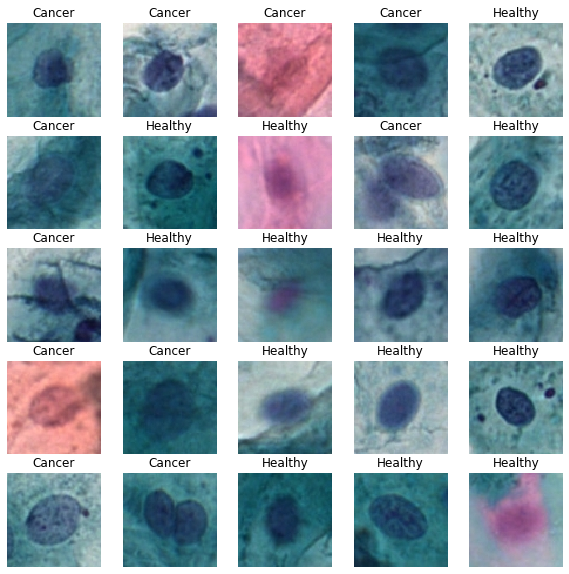

In [8]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(iter(train_model_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# **Prepare Model**

In [9]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0

# **Training**

In [10]:
history = model.fit(
    train_model_ds,
    steps_per_epoch=total_train*8 // BATCH_SIZE,
    epochs=epochs,
    validation_data=test_model_ds,
    validation_steps=total_test*8 // BATCH_SIZE,
    verbose=2)

Train for 4581 steps, validate for 3469 steps
Epoch 1/30
4581/4581 - 260s - loss: 0.1732 - accuracy: 0.9300 - val_loss: 0.8360 - val_accuracy: 0.6685
Epoch 2/30
4581/4581 - 251s - loss: 0.1035 - accuracy: 0.9607 - val_loss: 0.8797 - val_accuracy: 0.6863
Epoch 3/30
4581/4581 - 247s - loss: 0.0907 - accuracy: 0.9654 - val_loss: 1.1831 - val_accuracy: 0.6233
Epoch 4/30
4581/4581 - 248s - loss: 0.0829 - accuracy: 0.9683 - val_loss: 0.9283 - val_accuracy: 0.6864
Epoch 5/30
4581/4581 - 244s - loss: 0.0752 - accuracy: 0.9712 - val_loss: 1.0479 - val_accuracy: 0.6714
Epoch 6/30
4581/4581 - 241s - loss: 0.0699 - accuracy: 0.9732 - val_loss: 1.0096 - val_accuracy: 0.6883
Epoch 7/30
4581/4581 - 243s - loss: 0.0652 - accuracy: 0.9750 - val_loss: 0.9700 - val_accuracy: 0.6992
Epoch 8/30
4581/4581 - 248s - loss: 0.0615 - accuracy: 0.9762 - val_loss: 0.9348 - val_accuracy: 0.7056
Epoch 9/30
4581/4581 - 246s - loss: 0.0582 - accuracy: 0.9775 - val_loss: 1.1645 - val_accuracy: 0.6689
Epoch 10/30
4581/4

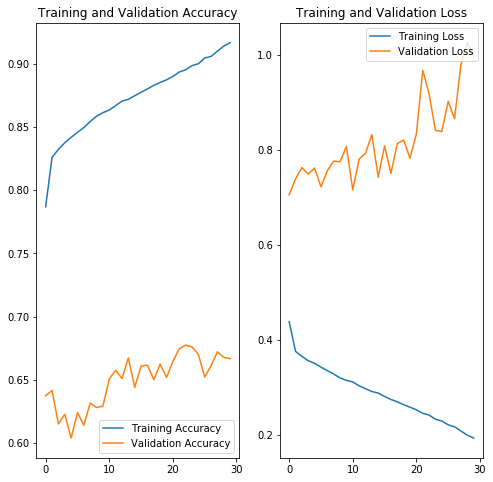

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()